# Zeitdiskrete Systeme im Frequenzbereich

In diesem Notebook wird gezeigt, wie man einfache zeitdiskrete Filter im Frequenzbereich charakterisieren kann, außerdem wird interaktiv demonstriert wie P/Z-Plan und Betragsgang zusammenhängen.

In [26]:
from __future__ import print_function, division
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
    
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import Image, display
from matplotlib import animation
from IPython.display import HTML
import numpy as np
from numpy import exp, cos, sin, pi
import scipy.signal as sig

import dsp_fpga_lib as dsp
dsp.versions()
plt.rcParams.update(dsp.mpl_rc) # define plot properties 
# plt.rcParams.update({'axes.grid':False}) # 

Python version: 3.6.4
Numpy: 1.14.0
Scipy: 1.0.0
Matplotlib: 2.1.2 module://ipykernel.pylab.backend_inline


## Zwei LTI-Systeme (nochmal)

Die folgenden Bilder zeigen nochmal die Systeme aus dem vorigen Kapitel.

![LTI-MA.png](../_img/LTI-MA.png)


![LTI-kask_MA.png](../_img/LTI-kask_MA.png)

Sind die Betragsgänge beider Filter identisch? Wir werden das im Folgenden ausprobieren. 

Zusätzlich verwenden wir jetzt einen verlusbehafteten Akkumulator / Integrator:

![LTI-Damped_integrator.png](../_img/LTI-Damped_integrator.png)

Zunächst betrachten wir noch einmal das Verhalten des Systems im Zeitbereich:

### Definition des Filters über seine Koeffizienten
In der nächsten Codezelle definieren wir das Filter über seine Koeffizienten. Bei FIR-Filtern sind die Koeffizienten identisch zur Impulsantwort (warum?):

In [27]:
b = np.ones(4); a = 1 # MA-filter, N = 5
b = np.convolve([1,1,1],[1,1,1]); a = 1 
# b = [1, 0]; a = [1, -0.9] # lossy integrator

## Impulsantwort des Filters
Wenn das Filter ein IIR System ist (z.B. der Lossy Integrator), kann die Impulsantwort nicht mehr direkt aus den Koeffizienten abgelesen werden. Hier wird die Funktion `impz(b,a,N) ` aus der `dsp_fpga_lib` verwendet. `N` ist ein optionaler Parameter, der die Anzahl der darzustellenden Impulse angibt.

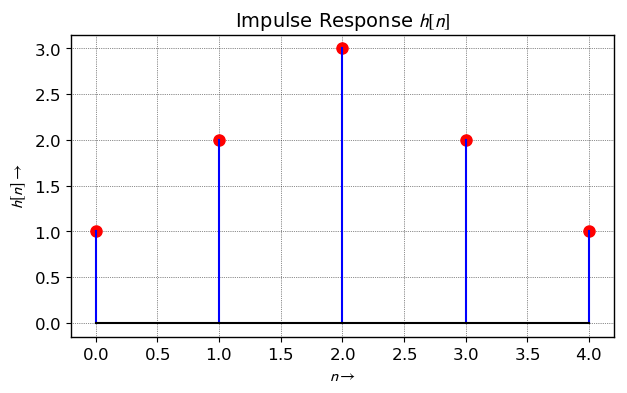

In [28]:
plt.figure()
h, n = dsp.impz(b,a) # calculate impulse response from coefficients
plt.stem(n, h, 'b-', 'ro', 'k') # plot h[n]
plt.xlabel(r'$n \rightarrow$'); plt.ylabel(r'$h[n] \rightarrow$');
plt.title(r'Impulse Response $h[n]$');

## Zeitdiskrete und "analoge Signale"
Auch hier definieren wir ein sinusförmiges Testsignal $x[n]$ mit Gleichanteil.

In [29]:
Ts = 1/200.0     # sampling period
fsig = 50.0      # signal frequency
phi0  = 0        # signal initial phase
tstep = 1e-3     # time step for "analog" signal
Tmax = 6.0/fsig  # timespan for 6 signal periods 
N_Ts = Tmax / Ts # number of samples in Tmax
# -- Calculate time-vectors and input signals ---
t = np.arange(0,Tmax,tstep)  # time t
n = np.arange(0,round(N_Ts)) # sample n (start,stop,step)
xt = 1.5 + 0.5*np.cos(2.0*np.pi*fsig*t + phi0) # x(t).
xn = 1.5 + 0.5*np.cos(2.0*np.pi*fsig*n*Ts + phi0) # x[n]

## Gefiltertes Signal im Zeitbereich
Auch hier falten wir das Testsignal $x[n]$ mit der Impulsantwort des Filters $h[n]$, um das Ausgangssignal $y[n]$ zu erhalten:

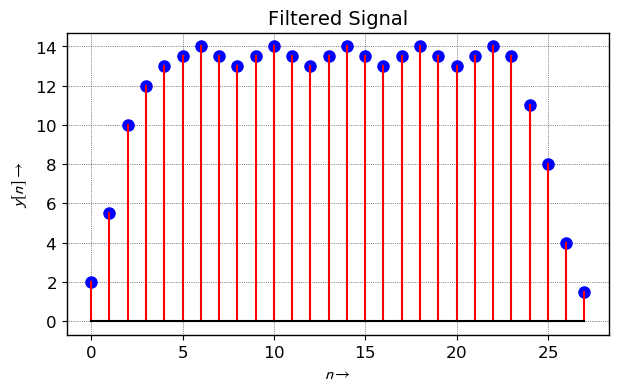

In [30]:
plt.figure()
yn = np.convolve(xn,h) # convolve signal and response
plt.stem(range(len(yn)), yn, 'r-', 'bo', 'k') # y[n]
plt.xlabel(r'$n \rightarrow$'); plt.ylabel(r'$y[n] \rightarrow$')
plt.title('Filtered Signal');

## Pol- und Nullstellendiagramm
Zunächst stellen wir das Pol-/Nullstellendiagramm des Filter dar:

[-0.50000002+0.8660254j -0.50000002-0.8660254j -0.49999998+0.8660254j
 -0.49999998-0.8660254j]


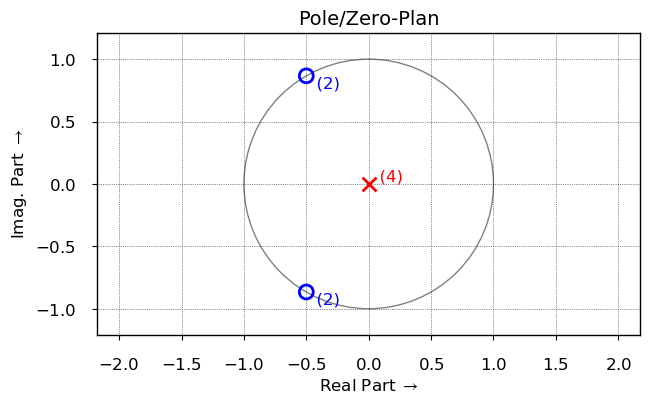

In [46]:
plt.figure()
plt.xlabel(r'Real Part $\rightarrow$'); plt.ylabel(r'Imag. Part $\rightarrow$')
plt.title('Pole/Zero-Plan')
dsp.zplane(b,a);
P = np.roots(b)
print(P)

## Betragsfrequenzgang
Als nächstes schauen wir uns den Betragsfrequenzgang an:

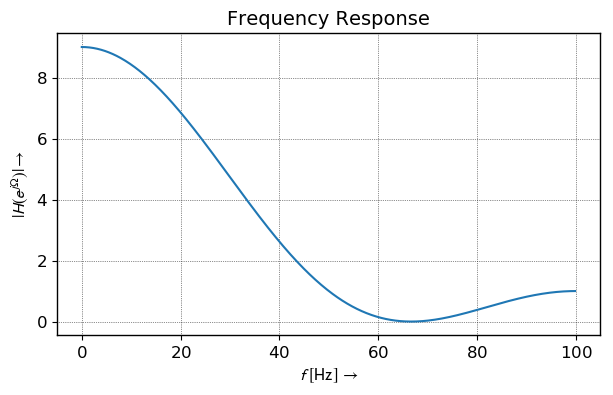

In [32]:
plt.figure()
[W, H] = sig.freqz(b, a, whole=0);
f = W  / (Ts * 2 * np.pi)
plt.plot(f,abs(H))
plt.ylabel(r'$|H(e^{j \Omega})| \rightarrow$')
plt.xlabel(r'$f \; \mathrm{ [Hz]} \, \rightarrow$')
plt.title('Frequency Response');

50 50
0.

TypeError: 'int' object is not subscriptable

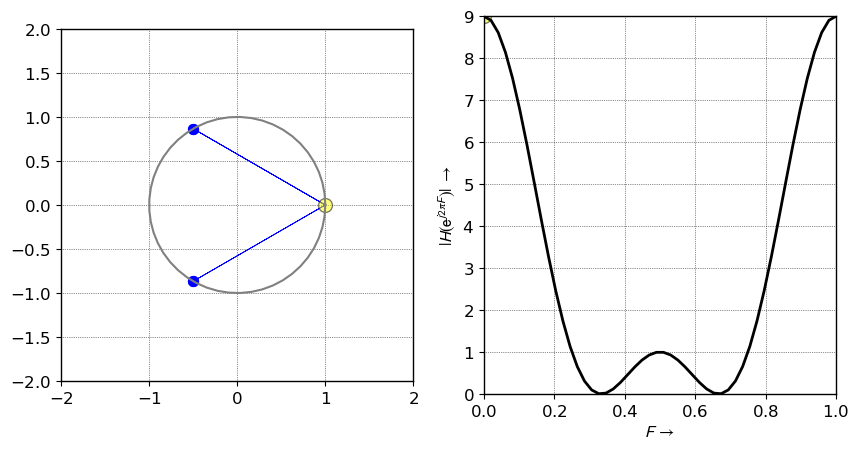

In [48]:
dpi = 100
fps = 30
N = 50 # number of frames
P = np.array([0.8* exp(1j * pi * 0.3), 0.8* exp(-1j * pi * 0.3)])
#P = np.array([-0.9])
P = np.roots(a)
If

Z = np.array([exp(1j * pi * 0.6), exp(-1j * pi * 0.6)])
#Z = 1/P # allpass
Z = np.roots(b)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(1)
#fig.clf()
fig.set_size_inches(10, 5, True)
ax1 = fig.add_subplot(121, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2),  aspect=1)
ax1.grid(True)
ax2 = fig.add_subplot(122, xlim=(0, 1), ylim=(0, 4))
ax2.set_xlabel(r"$F \; \rightarrow$")
ax2.set_ylabel(r"$|H \left( \mathrm{e}^{j 2 \pi F}\right) |\; \rightarrow$")
ax2.grid(True)

color_data = ['r', 'g', 'b']
scat = (0,0)

# Now pre-calculate coordinates along the unit circle and the distances 
phi = np.linspace(0, 1, N)
x_uc = cos(2*pi*phi)
y_uc = sin(2*pi*phi)

pl_x = []
pl_y = []
pl = 1
zl_x = []
zl_y = []
zl = 1
mag = []
for k in range(len(P)):
    pl *= np.abs(x_uc + 1j*y_uc - P[k])
for k in range(len(Z)):
    zl *= np.abs(x_uc + 1j*y_uc - Z[k])

mag = zl / pl
print(len(zl), len(mag))


line_p, = ax1.plot([],[], 'r', lw = 0.5) # line between poles and frequency point
line_z, = ax1.plot([],[], 'b', lw = 0.5) # line(s) between zeros and frequency point
point1, = ax1.plot([],[], 'o', ms = 10, mec = 'black',  mfc = 'yellow', alpha = 0.5)
text = ax1.text(-1.5,-1.5, "", ha = 'left', va = 'center')
line2, = ax2.plot([],[], 'o', ms = 10, mec = 'black',  mfc = 'yellow', alpha = 0.5)

# initialization function: plot the background for all frames
# this function is called at the beginning of each animation cycle
def init():
    ax1.plot(x_uc, y_uc, "grey") # plot unit circle
    ax1.scatter(P.real, P.imag, marker = "x", color = 'red', s = 50) # plot poles
    ax1.scatter(Z.real, Z.imag, marker = "o", color = 'blue', s = 50) # plot zeros
    ax2.plot(phi, mag, 'k', lw = 2)
    ax2.set_ylim([min(mag),max(mag)])
    line_p.set_data([], []) # dlear data for 
    line_z.set_data([], [])
    point1.set_data([], [])
    line2.set_data([], [])
    
    text.set_text('')
    return line_p, line_z, point1, line2,

# This is the actual animation function: The first argument is an integer that
# is incremented with each interation, the other arguments are defined in the
# fargs kw of FuncAnimation
# Arguments passed back are animated
# 
def animate(i, color_data, scat):
    print(i,'.', end='', sep='') # suppress endline terminator and white space between numbers
#    x2 = np.linspace(0, 1, N)
#    y2 = y2.append
#    y = np.sin(2 * np.pi * (x - 0.01 * i))
#    x = x_uc[i] #cos(2*pi * i / N)
#    y = y_uc[i]# = sin(2*pi * i / N)
    pl_x = []
    pl_y = []
    zl_x = []
    zl_y = []
    for k in range(len(P)):
        pl_x.append([x_uc[i], P[k].real])
        pl_y.append([y_uc[i], P[k].imag])
    for k in range(len(Z)):
        zl_x.append([x_uc[i], Z[k].real])
        zl_y.append([y_uc[i], Z[k].imag]) 
    line_p.set_data(pl_x, pl_y)
    line_z.set_data(zl_x, zl_y)


#    line2.set_data(phi[:i], mag[:i])
    line2.set_data(phi[i], mag[i])
    point1.set_data(x_uc[i],y_uc[i])
    text.set_text(
        str("ZL = %.2f" %(zl[i]) + "\n" + "PL = %.2f" %(pl[i]))  )
    return line_p, line_z, point1, line2, text

# Now call the animator:  
# blit=True: only re-draw the parts that have changed.
# frames: number of frames to be recorded
# interval: time between frames in ms = 1000/fps ; 
# total length = frames x interval
anim = animation.FuncAnimation(fig, animate, init_func=init, frames = N,
                               fargs=(color_data, scat)) #, 

anim

**Aufgaben:**
- Experimentieren Sie mit verschiedenen Längen für das MA-Filter, interpretieren Sie die Ergebnisse. Was passiert beim MA-Filter der Ordnung $N=3$?
- Lesen Sie die Unterdrückung des Gleichsignals aus den Betragsgang ab. Korrigieren Sie ggf. den Skalierungsfehler für DC-Signale im Code.

<hr>
**Copyright**

(c) 2016 - 2018 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp_fpga "Digitale Signalverarbeitung auf FPGAs"

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing auf FPGAs - Vorlesungsunterlagen mit Simulationsbeispielen, 2018*.